In [10]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy
from glob import glob
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
keras = tf.keras
SPLIT_WEIGHTS = (8, 1, 1)


In [11]:
#just declaring some UTILS functions
IMG_SIZE = 224
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


In [12]:
#load dataset in splitted sizes
raw_train,metadata = tfds.load("stanford_dogs", split="train[:80%]",with_info=True,as_supervised=True)
raw_test,metadata = tfds.load("stanford_dogs", split="train[81%:90%]",with_info=True,as_supervised=True)
raw_validation,metadata = tfds.load("stanford_dogs", split="train[91%:]",with_info=True,as_supervised=True)


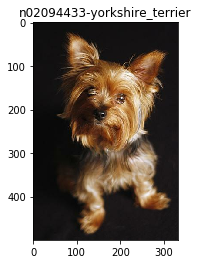

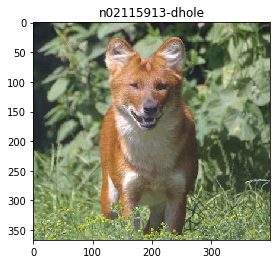

In [13]:
#check that the dataset has been loaded correctly
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


In [14]:
#resize all images to 300
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)



In [15]:
#shuffle and batch the data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000  

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [16]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)



In [17]:
for image_batch, label_batch in train_batches.take(1):
  pass 
image_batch.shape


TensorShape([32, 224, 224, 3])

In [18]:
# compile base model with global average pooling and prediction layer
model = tf.keras.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(133, activation='softmax'))



In [19]:
#train the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
#verify the model and trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 54, 54, 32)        1

In [23]:
num_train = (
  metadata.splits['train'].num_examples*8/10 
)
print(num_train)
num_val = (
  metadata.splits['train'].num_examples*1/10 
)
print(num_val)

num_test  = (
  metadata.splits['train'].num_examples*1/10 
)
print(num_test)


9600.0
1200.0
1200.0


In [24]:
steps_per_epoch = 10
validation_steps = 20
loss0,accuracy0 = model.evaluate(test_batches, steps = validation_steps)


20/20 [==============================] - 5s 250ms/step - loss: 42140.6441 - accuracy: 0.0000e+00


In [25]:
print("initial loss: {:.2f}".format(loss0))

print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 42140.64
initial accuracy: 0.00


In [ ]:
initial_epochs = 10

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
callbacks_list = [checkpointer]

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks_list,
                    validation_data=validation_batches,)


Epoch 1/10
     41/Unknown - 52s 1s/step - loss: 41114.5322 - accuracy: 7.6220e-04

In [ ]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')


In [ ]:
model.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks_list,
                    validation_data=validation_batches,)


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks_list,
                    validation_data=validation_batches,)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for layer in model.layers:
  layer.trainable =  True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))


In [ ]:
fine_tune_at = 100


In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()